### Imports 

In [1]:
import numpy as np
import pandas as pd
import json
#from dscribe.descriptors import CoulombMatrix
from ase import Atoms
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 22}

matplotlib.rc('font', **font)



In [2]:
def pad_with(vector, pad_width, iaxis, kwargs):
     pad_value = kwargs.get('padder', 10)
     vector[:pad_width[0]] = pad_value
     vector[-pad_width[1]:] = pad_value


def coulomb_matrix(atoms, n_atoms_max):
    # Creating a matrix with the product of the atomic numbers such that M_ij = Z[i]*Z[j]
    atomic_numbers = np.outer(atoms.get_atomic_numbers(),atoms.get_atomic_numbers())
    # Getting the distance matrix of the atoms object, such that element D_ij = |r_i - r_j|
    distances = atoms.get_all_distances()
    # Setting the diagonal elements, which are all zero, to 1 to avoid overflow errors
    np.fill_diagonal(distances, 1)
    
    # Creating the Cmat
    cmat = np.multiply(atomic_numbers, 1/distances) # Element wise multiplication
    np.fill_diagonal(cmat, 0.5*np.array(atoms.get_atomic_numbers())**2.4) # Filling the diagonal as described in the slides
    
    # Taking the sorted eigenvalues and padding with zeros such that all of the fingerprints have the same size
    shape = cmat.shape
    cmat,_ = np.linalg.eig(cmat)
    cmat = np.flip(np.sort(cmat))
    holder = np.zeros(n_atoms_max)
    holder[:shape[0]] = cmat
    cmat = holder
    
    return cmat



## Loading data and setting up the data frames

In [3]:
data_dir = "" # Specify your data path (Folder in which the files are placed)

In [4]:
# Loading the data as pandas DataFrame
train = pd.DataFrame(json.load(open(data_dir + "train.json", "rb")))
train = train[train.dynamic_stability_level != 1] # remove unstable
test = pd.DataFrame(json.load(open(data_dir + "test.json", "rb")))
## Transform atoms entry to ASE atoms object
train.atoms = train.atoms.apply(lambda x: Atoms(**x)) # OBS This one is important!
test.atoms = test.atoms.apply(lambda x: Atoms(**x))

In [5]:
print('Train data shape: {}'.format(train.shape))
train.head()

Train data shape: (1559, 5)


,formula,etot,dynamic_stability_level,atoms,Voigt_modulus
1,NiI2,-9.774512,2,"(Atom('Ni', [-7.814021732e-19, -1.673235808e-1...",31.358817
3,Hf4N3O2,-85.216280,3,"(Atom('Hf', [0.0, 1.8605461437, 11.1322923235]...",279.073400
6,Cr2Cl2Se2,-34.354062,3,"(Atom('Cr', [2.5217362911, 5.385447366e-16, 9....",47.686173
8,MoBrI,-13.552381,2,"(Atom('Mo', [1.543915598e-17, -1.192455131e-16...",15.989285
9,Tl2I6,-14.982825,2,"(Atom('Tl', [3.8955234015, 2.2490814845, 9.460...",5.012215


In [6]:
train.atoms[1]

Atoms(symbols='Hf4N3O2', pbc=[True, True, False], cell=[[3.2225604508, -6.60462343e-21, 0.0], [-1.6112802254, 2.7908192156, 0.0], [0.0, 0.0, 24.8736800674]])

In [7]:
print('Test data shape: {}'.format(test.shape))
test.head()

Test data shape: (264, 3)


,formula,etot,atoms
0,Ti2Te2,-21.567884,"(Atom('Te', [0.0001635792, 0.0005756553, 7.369..."
1,Cu2O2,-19.429111,"(Atom('Cu', [-3.606786318e-18, -0.0002926462, ..."
2,Y3C2,-33.214554,"(Atom('Y', [3.531761251e-18, -5.785592543e-18,..."
3,Ti2O4,-51.580206,"(Atom('Ti', [1.135647763e-19, 0.0301387729, 8...."
4,BiMoAs,-19.967820,"(Atom('Mo', [6.983934515e-18, 2.357780987e-16,..."


In [8]:
test.atoms[1]

Atoms(symbols='CuOCuO', pbc=[True, True, False], cell=[[2.8049685284, 1.734570062e-17, 0.0], [-3.746612841e-17, 5.602487274, 0.0], [-7.217855535e-18, 0.0, 16.9711719]])

In [9]:
np.unique(train.dynamic_stability_level,return_counts=True)

(array([2, 3], dtype=int64), array([ 538, 1021], dtype=int64))

## Creating the Coulomb matrix fingerprint
#### First a preprocessing step

In [10]:
species = []
number_of_atoms = []
atomic_numbers = []
for atom in pd.concat([train.atoms,test.atoms]):
    species = list(set(species+atom.get_chemical_symbols()))
    atomic_numbers = list(set(atomic_numbers+list(atom.get_atomic_numbers())))
    number_of_atoms.append(atom.get_number_of_atoms())

max_number_of_atoms = np.max(number_of_atoms)
min_atomic_number = np.min(atomic_numbers)
max_atomic_number = np.max(atomic_numbers)

print(max_number_of_atoms)

12


C:\software\anoconda\lib\site-packages\ase\atoms.py:971: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


#### Coulomb matrix

In [11]:
cmats = np.zeros((len(train),max_number_of_atoms))
for i,atoms in enumerate(train.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix(atoms,max_number_of_atoms)
    cmats[i,:] = cmat.flatten()
print(len(cmats))

0
1000
1559


In [12]:
cmat.shape

(12,)

In [13]:
print(len(cmats), cmats.shape)

1559 (1559, 12)


# Setting target and feature vector

In [14]:
X = pd.DataFrame(data = cmats, index=train.index)
y = train['Voigt_modulus']
print('X: {}'.format(X.shape))
print('y: {}'.format(y.shape))

X: (1559, 12)
y: (1559,)


## Splitting into test and train set

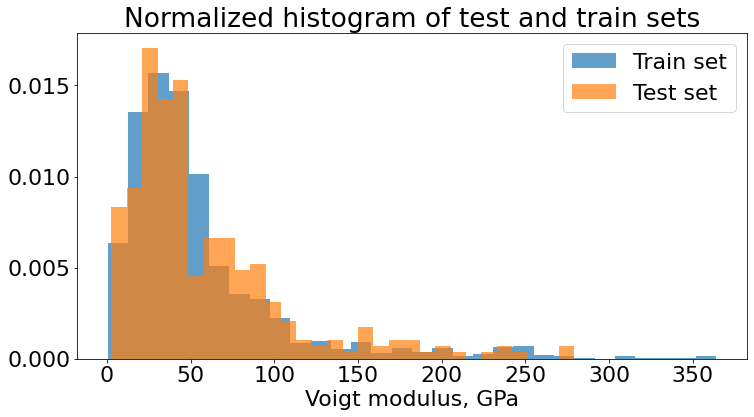

In [15]:
from sklearn.model_selection import train_test_split

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=250)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

plt.figure(figsize = (12, 6))
plt.hist(y_train, bins=30, alpha=0.7, density=True, label='Train set')
plt.hist(y_test, bins=30, alpha=0.7, density=True, label='Test set')

plt.title("Normalized histogram of test and train sets")
plt.xlabel("Voigt modulus, GPa")
plt.legend()
plt.show()


In [16]:
print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (1247, 12)
y_train: (1247,)
X_test: (312, 12)
y_test: (312,)


In [17]:
X_train[:5]

,0,1,2,3,4,5,6,7,8,9,10,11
887,5490.857496,3853.256619,445.617122,391.321010,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
649,19221.960627,15639.167682,841.163616,382.715562,332.139288,327.681171,295.308308,294.87635,220.469271,193.129137,0.0,0.0
1088,5943.406264,2380.453814,2107.945173,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
378,7759.975718,5901.387719,3495.729014,2974.757876,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0
836,6080.774905,2265.179189,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0


# Sklearn Ridge Regression model

In [18]:
# from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
# from sklearn.preprocessing import StandardScaler

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

In [19]:
# scaler = StandardScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [30]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.gaussian_process.kernels import RationalQuadratic

# Instantiate a Gaussian Process model
# kernel = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=0.00207, alpha=0.263, length_scale_bounds=(1e-05, 100000.0), alpha_bounds=(1e-05, 100000.0))
kernel = C(1.0, (1e-3, 1e3)) * RationalQuadratic(length_scale=0.00207, alpha=0.263)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train, y_train)

# Make the prediction on the meshed x-axis (ask for MSE as well)

C:\software\anoconda\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RationalQuadratic(alpha=0.263, length_scale=0.00207),
                         n_restarts_optimizer=10, normalize_y=True)

In [21]:
# X_train,X_test,y_train,y_test

In [22]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

# kernel = DotProduct() + WhiteKernel()
# gp = GaussianProcessRegressor(kernel=kernel, random_state=0)

# gp.fit(X_train, y_train)

In [23]:
gp.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel__k1': 1**2,
 'kernel__k2': RationalQuadratic(alpha=0.263, length_scale=0.00207),
 'kernel__k1__constant_value': 1.0,
 'kernel__k1__constant_value_bounds': (0.001, 1000.0),
 'kernel__k2__length_scale': 0.00207,
 'kernel__k2__alpha': 0.263,
 'kernel__k2__length_scale_bounds': (1e-05, 100000.0),
 'kernel__k2__alpha_bounds': (1e-05, 100000.0),
 'kernel': 1**2 * RationalQuadratic(alpha=0.263, length_scale=0.00207),
 'n_restarts_optimizer': 10,
 'normalize_y': True,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [24]:
train_prediction = gp.predict(X_train)
# train_prediction
test_prediction = gp.predict(X_test)
# test_prediction

In [25]:
# test_prediction = model.predict(X_test)

In [26]:
print('Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
print('Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))

Train RMSE = 0.04
Test RMSE = 30.20


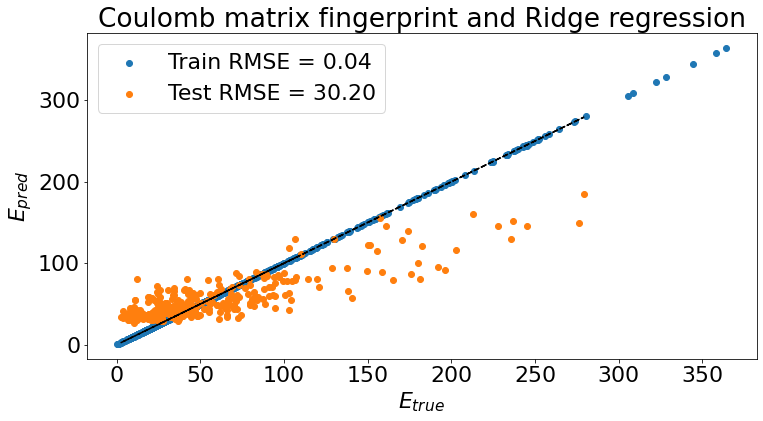

In [27]:
fig = plt.figure(figsize = (12, 6))

plt.title("Coulomb matrix fingerprint and Ridge regression")
plt.scatter(y_train, gp.predict(X_train), label = 'Train RMSE = {:.2f}'.format(rmse(y_train,train_prediction)))
plt.scatter(y_test, gp.predict(X_test), label = 'Test RMSE = {:.2f}'.format(rmse(y_test,test_prediction)))
plt.plot(y_test, y_test, linestyle = "--", color = "k")
plt.xlabel("$E_{true}$")
plt.ylabel("$E_{pred}$")
plt.legend()
plt.show()

# Prepare submission to Kaggle

In [28]:
cmats_test = np.zeros((len(test),max_number_of_atoms))
for i,atoms in enumerate(test.atoms):
    if i%1000 == 0:
        print(i)
    cmat = coulomb_matrix(atoms,max_number_of_atoms)
    cmats_test[i,:] = cmat.flatten()
print(len(cmats))

0
1559


In [29]:
X_test_kaggle = pd.DataFrame(data = cmats_test, index=test.index)
X_test_kaggle.loc[:,:] = scaler.transform(X_test_kaggle)
X_test_kaggle.head()

NameError: name 'scaler' is not defined

In [ ]:
test_prediction_dataframe = pd.DataFrame(data = {'ID':test.index,
                                                 'Voigt_modulus':model.predict(X_test_kaggle)})
test_prediction_dataframe.head()

In [ ]:
test_prediction_dataframe.to_csv(data_dir+'submission_test.csv',index=False)